In [1]:
import numpy
import pandas as pd
import numpy as np
import os
# data_dict df_dict
# Output: df_dict
# Define path to parent directory containing subdirectories with CSV files
parent_dir = './sc sensor/'

# Initialize an empty dictionary to hold the dataframes
df_dict = {}

# Loop through each subdirectory in the parent directory
for subdir, dirs, files in os.walk(parent_dir):
    # Initialize an empty list to hold the dataframes for this subdirectory
    df_list = []
    # Loop through each file in the subdirectory
    files.sort()
    for filename in files:
        # Check if the file is a CSV file
        if filename.endswith('.csv'):
            # Read the CSV file into a dataframe
            df = pd.read_csv(os.path.join(subdir, filename), sep="\t", index_col="Index")
            # Append the dataframe to the list
            col_name = os.path.splitext(filename)[0]
            # df_list.append(df['Sum'][:217].rename(col_name))
            flow_data = np.stack([df["Left to Right"].values, df["Right to Left"].values, df["Sum"].values], axis=1)
            df_list.append(pd.Series([row for row in flow_data], name = col_name))
            # df_list.append(df['Sum'].rename(col_name))
    # Concatenate all dataframes for this subdirectory into a single dataframe

    if df_list:
        df_concatenated = pd.concat(df_list, axis=1)
        # print(subdir)
        sorted_cols = sorted(df_concatenated.columns, key=lambda x: int(x.split('_')[1])) # sort the column name
        df_concatenated = df_concatenated.reindex(columns=sorted_cols)
        # Add the concatenated dataframe to the dictionary with the subdirectory name as the key
        df_dict[subdir] = df_concatenated

In [2]:
# process sc sensor 2
import pandas as pd
import numpy as np
import os

# Define path to parent directory containing subdirectories with CSV files
parent_dir = './sc sensor 2/'
# adding to the df_dict
# Loop through each subdirectory in the parent directory
for subdir, dirs, files in os.walk(parent_dir):
    # Initialize an empty list to hold the dataframes for this subdirectory
    df_list = []
    # Loop through each file in the subdirectory
    files.sort()
    for filename in files:
        # Check if the file is a Excel file
        if filename.endswith('.xlsx'):
            df = pd.read_excel(subdir + '/' + filename, header=None, index_col=0)
            df = df.T
            temp = df.columns
            for i in range(len(temp)):
                if pd.isna(temp[i]):
                    df.iloc[:, i] = df.iloc[:, i-2] + df.iloc[:, i-1]
                    df = df.rename(columns={df.columns[i]: 'Sum'})

            # add a new column that contains the sum of the last two columns
            df.insert(df.shape[1], '', df.iloc[:, -2] + df.iloc[:, -1])
            # rename the last column to "Sum"
            df = df.rename(columns={df.columns[-1]: "Sum"})
            for i in range(len(temp)):
                if df.columns[i] == "Station_hall_layer" or df.columns[i] == "Platform_layer":
                    sub_df = df.iloc[:,i+1:i+5]
                    flow_data = np.stack([sub_df["Left to Right"].values, sub_df["Right to Left"].values, sub_df["Sum"].values], axis=1).astype("int")
                    df_list.append(pd.Series([row for row in flow_data], name = "sensor_" + df.iloc[0, i].split(" ")[1]))

        if df_list:
            df_concatenated = pd.concat(df_list, axis=1)
            # print(subdir)
            sorted_cols = sorted(df_concatenated.columns, key=lambda x: int(x.split('_')[1])) # sort the column name
            df_concatenated = df_concatenated.reindex(columns=sorted_cols)
            # Add the concatenated dataframe to the dictionary with the subdirectory name as the key
            df_dict[subdir] = df_concatenated

In [3]:
# Generate data to datadict, process data to matrix
data_dict = {}
for k in df_dict.keys():
    mat_list = []
    for col in df_dict[k].columns:
        mat_list.append(np.array(df_dict[k][col].values.tolist()))
    data_dict[k] = np.stack(mat_list, axis=1)

## Generate in-sample testing

In [5]:
# Extract features and label, refer to scripts in dcrnn
# Train is the original data without label
import random
save_mode = False

all_x, all_y = [], []
for scenario in data_dict.keys(): 
    data = data_dict[scenario]
    x_offsets = np.sort(
            # np.concatenate(([-week_size + 1, -day_size + 1], np.arange(-11, 1, 1)))
            np.concatenate((np.arange(-11, 1, 1),))
        )
        # Predict the next one hour
    y_offsets = np.sort(np.arange(1, 13, 1))
    min_t = abs(min(x_offsets))
    max_t = abs(data.shape[0]- abs(max(y_offsets)))

    # max_t = abs(N - abs(max(y_offsets)))  # Exclusive
    x, y = [], []
    for t in range(min_t, max_t):
        x_t = data[t + x_offsets, ...]
        y_t = data[t + y_offsets, ...]
        x.append(x_t)
        y.append(y_t)

    x = np.stack(x, axis=0)
    y = np.stack(y, axis=0)
    
    all_x.append(x)
    all_y.append(y)

zipped_lists = list(zip(all_x, all_y))
random.shuffle(zipped_lists)  # shuffle data
all_x, all_y = zip(*zipped_lists)

x = np.concatenate(all_x, axis=0)
y = np.concatenate(all_y, axis=0)

# divide dataset
num_samples, num_nodes = x.shape[0], x.shape[1]  # num_samples = ts - 12*2 +1

len_train = round(num_samples * 0.7)
len_val = round(num_samples * 0.1)
x_train, y_train = x[: len_train, ...], y[: len_train, ...]
x_val, y_val = x[len_train: len_train + len_val, ...], y[len_train: len_train + len_val, ...]
x_test, y_test = x[len_train + len_val:, ...], y[len_train + len_val:, ...]

if save_mode:
    for cat in ["train", "val", "test"]:
        _x, _y = locals()["x_" + cat], locals()["y_" + cat]
        np.savez_compressed(
        os.path.join("./dataset", "%s.npz" % cat),
        x=_x,
        y=_y,
        # x_offsets=x_offsets.reshape(list(x_offsets.shape) + [1]),
        # y_offsets=y_offsets.reshape(list(y_offsets.shape) + [1]),
    )

In [173]:
y_test.shape[0]

1751

## Generate ood testing

In [80]:
data_dict['./sc sensor/sc12_2'].shape

(361, 35, 3)

In [4]:
train_sc = ['./sc sensor/sc4_2', './sc sensor/sc13', './sc sensor/sc1',
            './sc sensor/sc6', './sc sensor/sc7_2', './sc sensor/sc7',
            './sc sensor/sc3_2', './sc sensor/sc6_2', './sc sensor/sc2_2',
            './sc sensor/sc13_2', './sc sensor/sc5', './sc sensor/sc2',
            './sc sensor/sc5_2', './sc sensor/sc3', './sc sensor/sc4']
test_sc = []
for sc in data_dict.keys():
    if sc not in train_sc:
        test_sc.append(sc)

In [5]:
# This cell for generating ood dataset
import random
all_x, all_y, all_test_x, all_test_y = [], [], [], []
save_mode = False
for scenario in data_dict.keys():
    data = data_dict[scenario]
    x_offsets = np.sort(
            # np.concatenate(([-week_size + 1, -day_size + 1], np.arange(-11, 1, 1)))
            np.concatenate((np.arange(-11, 1, 1),))
        )
        # Predict the next one hour
    y_offsets = np.sort(np.arange(1, 13, 1))
    min_t = abs(min(x_offsets))
    max_t = abs(data.shape[0]- abs(max(y_offsets)))

    # max_t = abs(N - abs(max(y_offsets)))  # Exclusive
    x_train, y_train, x_test, y_test = [], [], [], []
    for t in range(min_t, max_t):
        x_t = data[t + x_offsets, ...]
        y_t = data[t + y_offsets, ...]
        if scenario in train_sc:
            x_train.append(x_t)
            y_train.append(y_t)
        else:
            x_test.append(x_t)
            y_test.append(y_t)

    # divide train scenerio and test
    if scenario in train_sc:
        x_train = np.stack(x_train, axis=0)
        y_train = np.stack(y_train, axis=0)
        all_x.append(x_train)
        all_y.append(y_train)
    else:
        x_test = np.stack(x_test, axis=0)
        y_test = np.stack(y_test, axis=0)
        all_test_x.append(x_test)
        all_test_y.append(y_test)



zipped_lists = list(zip(all_x, all_y))
random.shuffle(zipped_lists)  # shuffle data
all_x, all_y = zip(*zipped_lists)

x = np.concatenate(all_x, axis=0)
y = np.concatenate(all_y, axis=0)



num_samples, num_nodes = x.shape[0], x.shape[2]  # num_samples = ts - 12*2 +1
len_train = round(num_samples * 0.8)
# len_val = round(num_samples * 0.1)
x_train, y_train = x[: len_train, ...], y[: len_train, ...]
x_val, y_val = x[len_train:, ...], y[len_train:, ...]
x_test, y_test = np.concatenate(all_test_x, axis=0), np.concatenate(all_test_y, axis=0)

if save_mode:
    for cat in ["train", "val", "test"]:
        _x, _y = locals()["x_" + cat], locals()["y_" + cat]
        np.savez_compressed(
        os.path.join("./ood_dataset", "%s.npz" % cat),
        x=_x,
        y=_y,
        # x_offsets=x_offsets.reshape(list(x_offsets.shape) + [1]),
        # y_offsets=y_offsets.reshape(list(y_offsets.shape) + [1]),
    )

In [177]:
x_val.shape

(829, 12, 35, 3)

## Output data_dict, df_dict, shuffled x y and x y

# Visualization

In [6]:
test_sc

['./sc sensor/sc12_2',
 './sc sensor/sc12',
 './sc sensor/sc8',
 './sc sensor/sc11_2',
 './sc sensor/sc9',
 './sc sensor/sc9_2',
 './sc sensor/sc10_2',
 './sc sensor/sc8_2',
 './sc sensor/sc10',
 './sc sensor/sc11',
 './sc sensor 2/sc14',
 './sc sensor 2/sc15',
 './sc sensor 2/sc15_2',
 './sc sensor 2/sc14_2']

In [587]:
from lib.utils import load_dataset, sliding_win#, load_dataset_rnn
mode = "OOD"
if mode == "insample":
    data = load_dataset("./dataset", batch_size=64, test_batch_size=64)
else:
    data = load_dataset("./ood_dataset", batch_size=64, test_batch_size=64)

vis_data = data_dict[test_sc[1]].astype("float64") # after sliding window
source, target = sliding_win(vis_data)  # process data into continuous sample data
for i in range(3): #3 feature num
    source[..., i] = data["scalers"][i].transform(source[..., i])  # input data
    target[..., i] = data["scalers"][i].transform(target[..., i])  # ground truth

In [588]:
node = 2 - 1 #after 3 min
step = 0
feat = 2
vis_list, model_names = [], []

In [589]:
#var
from baselines.VAR_v2 import VAR
num_nodes = 35
features = 3
inpt_dim = features * num_nodes
train_steps = 3
seq_len = 12 ## here lags = 3, so

loaded_model = VAR(inpt_dim, step=train_steps)
if mode == "Insample":
    loaded_model.load(f'./result/VAR/VAR.npy')
else:
    loaded_model.load(f'./result/VAR/VAR_ood.npy')

pred = loaded_model.predict(source[:, -train_steps:,:,:].reshape([-1, train_steps*num_nodes*features]))
vis = pred.reshape(-1, seq_len, num_nodes, features)[:, step, node, feat]  # bc, steps, nodes, features
gt = target[:, step, node, feat]

#for plotting figures
vis_list.append(pred.reshape(-1, seq_len, num_nodes, features))
model_names.append("VAR")

x_aixs = np.arange(vis.shape[0])
# plt.figure(figsize=(20,10))
# plt.plot(x_aixs, vis, label='pred')
# plt.plot(x_aixs, gt, label='ground truth')
# plt.legend(fontsize=20)


In [590]:
# var v1
outputs = []
loaded_models = []
# source_xgb, target_xgb = sliding_win(vis_data)
for j in range(num_nodes):
    loaded_model = VAR(inpt_dim=3, step=train_steps)
    # loaded_model.load_model(f'./result/boost/xgb_regressor{j}.model')
    if mode == "Insample":
        loaded_model.load(f'./result/VAR/VAR{j}.npy')
    else:
        loaded_model.load(f'./result/VAR/VAR_ood{j}.npy')

    output = loaded_model.predict(source[:, -train_steps:,j,:].reshape([-1, train_steps*3]))
    output = output.reshape([-1, seq_len, source.shape[3]])
    outputs.append(output)


pred = np.stack(outputs, axis=2)

vis = pred[:, step, node, feat]  # bc, steps, nodes, features
gt = target[:, step, node, feat]
vis_list.append(pred)
model_names.append("VAR v1")

x_aixs = np.arange(vis.shape[0])
# plt.figure(figsize=(20,10))
# plt.plot(x_aixs, vis, label='pred')
# plt.plot(x_aixs, gt, label='ground truth')
# plt.legend(fontsize=20)
# plt.show()

In [591]:
## Visualization for model output
from lib.utils import build_graph
import torch
import numpy as np
from baselines.DCRNN import DCRNNModel

G = build_graph()
adj_mat = G.adjacency_matrix(transpose=False, scipy_fmt="csr")
adj_mat.setdiag(1)

class args():
    def __init__(self):
        pass
args = args()

args.batch_size = source.shape[0]
args.enc_input_dim = 3  # encoder network input size, can be 1 or 3
args.dec_input_dim = 3  # decoder input
args.max_diffusion_step = 2
args.num_nodes = 35
args.num_rnn_layers = 2
args.rnn_units = 64
args.seq_len = 12
args.output_dim = 3
args.filter_type = "dual_random_walk"
args.max_grad_norm = 5
args.cl_decay_steps = 2000
args.scalers = data["scalers"]
args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Users/mmai/anaconda3/envs/mps/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [592]:
model = DCRNNModel(adj_mat, args)
if mode == "Insample":
    model.load_state_dict(torch.load("./result/dcrnn.pt"))
else:
    model.load_state_dict(torch.load("./result/dcrnn_ood.pt"))
pred = model(torch.tensor(source).float(), torch.zeros([source.shape[0], 12, args.num_nodes, args.enc_input_dim]), 0)

In [593]:
# pred = model(torch.tensor(source).float(), torch.zeros([source.shape[0], 12, args.num_nodes, args.enc_input_dim]), 0)
model.eval()
vis = pred[:, step, node, feat].detach()  # bc, steps, nodes, features
gt = target[:, step, node, feat]
pred = pred.detach().numpy()
vis_list.append(pred)

model_names.append("DCRNN")
# gt = vis_data[23:,node,feat]
# gt = transform_data_y[:, step, :, :]
x_aixs = np.arange(vis.shape[0])
# plt.figure(figsize=(20,10))
# plt.plot(x_aixs, vis, label='pred')
# plt.plot(x_aixs, gt, label='ground truth')
# plt.legend(fontsize=20)
# plt.show()

In [594]:
from baselines.RNN import Seq2seq
args.batch_size = source.shape[0]
args.num_nodes = 35
# dec_input_dim = 3  # decoder input
args.dec_input_dim = 3 * args.num_nodes  # decoder input
args.enc_input_dim = 3 * args.num_nodes # encoder network input size, can be 1 or 3
args.features = 3
args.num_rnn_layers = 2
args.rnn_units = 64
args.seq_len = 12
args.output_dim = 3 * args.num_nodes
model_rnn = Seq2seq(args)
if mode == "Insample":
    model_rnn.load_state_dict(torch.load("./result/rnn.pt"))
else:
    model_rnn.load_state_dict(torch.load("./result/rnn_ood.pt"))

In [595]:
# seq2seq
inpt = torch.tensor(source).float()
pred = model_rnn(inpt, torch.zeros_like(inpt), 0)

In [596]:
vis = pred[:, step, node, feat].detach()  # bc, steps, nodes, features
gt = target[:, step, node, feat]
pred = pred.detach().numpy()
vis_list.append(pred)
# gt_list.append(target)
model_names.append("RNN Seq2seq")
# gt = vis_data[23:,node,feat]
# gt = transform_data_y[:, step, :, :]
x_aixs = np.arange(vis.shape[0])
# plt.figure(figsize=(20,10))
# plt.plot(x_aixs, vis, label='pred')
# plt.plot(x_aixs, gt, label='ground truth')
# plt.legend(fontsize=20)
# plt.show()

In [597]:
#RNN
from tensorflow.keras.models import load_model
args.seq_len = 12
args.num_nodes = 35
args.features = 3
if mode == "Insample":
    loaded_model = load_model('./result/RNN keras.h5')
else:
    loaded_model = load_model('./result/RNN keras ood.h5')
pred = loaded_model.predict(source.reshape([-1, args.seq_len, args.num_nodes * args.features]))
pred = pred.reshape([args.batch_size, args.seq_len, args.num_nodes, args.features])

11/11 [==============================] - 0s 1ms/step


In [598]:
vis = pred[:, step, node, feat]  # bc, steps, nodes, features
gt = target[:, step, node, feat]
# pred = pred.detach()
vis_list.append(pred)
# gt_list.append(target)
model_names.append("RNN")
# gt = vis_data[23:,node,feat]
# gt = transform_data_y[:, step, :, :]
x_aixs = np.arange(vis.shape[0])
# plt.figure(figsize=(20,10))
# plt.plot(x_aixs, vis, label='pred')
# plt.plot(x_aixs, gt, label='ground truth')
# plt.legend(fontsize=20)
# plt.show()

In [599]:
#xgboost
import xgboost as xgb
num_nodes = 35
output_dim = 3
seq_len = 12

loaded_model = xgb.Booster()
if mode == "Insample":
    loaded_model.load_model('./result/boost/xgb_regressor.model')
elif mode == "OOD":
    loaded_model.load_model('./result/boost/xgb_regressor_ood.model')
else:
    pass
# source_xgb, target_xgb = sliding_win(vis_data)

pred = loaded_model.predict(xgb.DMatrix(source.reshape(-1, num_nodes * output_dim * seq_len)))
vis = pred.reshape(-1, seq_len, num_nodes, output_dim)[:, step, node, feat]  # bc, steps, nodes, features
gt = target[:, step, node, feat]
vis_list.append(pred.reshape(-1, seq_len, num_nodes, output_dim))
# gt_list.append(target)
model_names.append("XGBOOST")

x_aixs = np.arange(vis.shape[0])
# plt.figure(figsize=(20,10))
# plt.plot(x_aixs, vis, label='pred')
# plt.plot(x_aixs, gt, label='ground truth')
# plt.legend(fontsize=20)
# plt.show()

In [600]:
# XGBOOST v2
import xgboost as xgb
num_nodes = 35
output_dim = 3
seq_len = 12

outputs = []
loaded_models = []
# source_xgb, target_xgb = sliding_win(vis_data)
for j in range(num_nodes):
    loaded_model = xgb.Booster()
    # loaded_model.load_model(f'./result/boost/xgb_regressor{j}.model')
    if mode == "Insample":
        loaded_model.load_model(f'./result/boost/xgb_regressor{j}.model')
    else:
        loaded_model.load_model(f'./result/boost/xgb_regressor_ood{j}.model')
    output = loaded_model.predict(xgb.DMatrix(source[:,:,j,:].reshape([-1, seq_len*source.shape[3]])))
    output = output.reshape([-1, seq_len, source.shape[3]])
    outputs.append(output)


pred = np.stack(outputs, axis=2)

vis = pred[:, step, node, feat]  # bc, steps, nodes, features
gt = target[:, step, node, feat]
vis_list.append(pred)
# gt_list.append(target)
model_names.append("XGBOOST v1")
# gt = vis_data[23:,node,feat]
# gt = transform_data_y[:, step, :, :]
x_aixs = np.arange(vis.shape[0])
# plt.figure(figsize=(20,10))
# plt.plot(x_aixs, vis, label='pred')
# plt.plot(x_aixs, gt, label='ground truth')
# plt.legend(fontsize=20)
# plt.show()

In [601]:
# MLP
import pickle
num_nodes = 35
output_dim = 3
seq_len = 12

if mode == "Insample":
    loaded_model = pickle.load(open('./result/mlp/MLP.sav', 'rb'))
else:
    loaded_model = pickle.load(open('./result/mlp/MLP_ood.sav', 'rb'))
# source_xgb, target_xgb = sliding_win(vis_data)

pred = loaded_model.predict(source.reshape(-1, num_nodes * output_dim * seq_len))
vis = pred.reshape(-1, seq_len, num_nodes, output_dim)[:, step, node, feat]  # bc, steps, nodes, features
gt = target[:, step, node, feat]
vis_list.append(pred.reshape(-1, seq_len, num_nodes, output_dim))
# gt_list.append(target)
model_names.append("MLP")

x_aixs = np.arange(vis.shape[0])
# plt.figure(figsize=(20,10))
# plt.plot(x_aixs, vis, label='pred')
# plt.plot(x_aixs, gt, label='ground truth')
# plt.savefig("./fig/illus.pdf")
# plt.legend(fontsize=20)
# plt.show()

In [602]:
#MLP v1
import pickle
num_nodes = 35
output_dim = 3
seq_len = 12

outputs = []
loaded_models = []
# source_xgb, target_xgb = sliding_win(vis_data)
for j in range(num_nodes):
    if mode == "Insample":
        loaded_model = pickle.load(open(f'./result/mlp/MLP{j}.sav', 'rb'))
    else:
        loaded_model = pickle.load(open(f'./result/mlp/MLP_ood{j}.sav', 'rb'))

    output = loaded_model.predict(source[:,:,j,:].reshape([-1, seq_len*source.shape[3]])) # 12 * 3
    output = output.reshape([-1, seq_len, source.shape[3]])
    outputs.append(output)


pred = np.stack(outputs, axis=2)


# pred = loaded_model.predict(xgb.DMatrix(source_xgb.reshape(-1, num_nodes * output_dim * seq_len)))
vis = pred[:, step, node, feat]  # bc, steps, nodes, features
gt = target[:, step, node, feat]
vis_list.append(pred.reshape(-1, seq_len, num_nodes, output_dim))
# gt_list.append(target)
model_names.append("MLP v1")

x_aixs = np.arange(vis.shape[0])
# plt.figure(figsize=(20,10))
# plt.plot(x_aixs, vis, label='pred')
# plt.plot(x_aixs, gt, label='ground truth')
# plt.legend(fontsize=20)
# plt.show()

In [603]:
# LR
import pickle
num_nodes = 35
output_dim = 3
seq_len = 12

if mode == "Insample":
    loaded_model = pickle.load(open('./result/linear/LR_regressor.sav', 'rb'))
else:
    loaded_model = pickle.load(open('./result/linear/LR_regressor_ood.sav', 'rb'))

pred = loaded_model.predict(source.reshape(-1, num_nodes * output_dim * seq_len))
vis = pred.reshape(-1, seq_len, num_nodes, output_dim)[:, step, node, feat]  # bc, steps, nodes, features
gt = target[:, step, node, feat]
vis_list.append(pred.reshape(-1, seq_len, num_nodes, output_dim))
# gt_list.append(target)
model_names.append("MLR")
# gt = vis_data[23:,node,feat]
# gt = transform_data_y[:, step, :, :]
x_aixs = np.arange(vis.shape[0])
# plt.figure(figsize=(20,10))
# plt.plot(x_aixs, vis, label='pred')
# plt.plot(x_aixs, gt, label='ground truth')
# plt.legend(fontsize=20)
# plt.show()

In [604]:
#LR
import pickle
num_nodes = 35
output_dim = 3
seq_len = 12

outputs = []
loaded_models = []
# source_xgb, target_xgb = sliding_win(vis_data)
for j in range(num_nodes):
    if mode == "Insample":
        loaded_model = pickle.load(open(f'./result/linear/LR_regressor{j}.sav', 'rb'))
    else:
        loaded_model = pickle.load(open(f'./result/linear/LR_regressor_ood{j}.sav', 'rb'))

    output = loaded_model.predict(source[:,:,j,:].reshape([-1, seq_len*source.shape[3]])) # 12 * 3
    output = output.reshape([-1, seq_len, source.shape[3]])
    outputs.append(output)


pred = np.stack(outputs, axis=2)


# pred = loaded_model.predict(xgb.DMatrix(source_xgb.reshape(-1, num_nodes * output_dim * seq_len)))
vis = pred[:, step, node, feat]  # bc, steps, nodes, features
gt = target[:, step, node, feat]
vis_list.append(pred.reshape(-1, seq_len, num_nodes, output_dim))
# gt_list.append(target)
model_names.append("MLR v1")

x_aixs = np.arange(vis.shape[0])
# plt.figure(figsize=(20,10))
# plt.plot(x_aixs, vis, label='pred')
# plt.plot(x_aixs, gt, label='ground truth')
# plt.legend(fontsize=20)
# plt.show()

In [605]:
#Inverse transform the data
for i in range(3): #3 feature num
    for pred in vis_list:
        pred[..., i] = data["scalers"][i].inverse_transform(pred[..., i])  # input data
    target[..., i] = data["scalers"][i].inverse_transform(target[..., i])  # ground truth

### Quantile Loss and Rho Risk

In [606]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.lib.stride_tricks import as_strided

def rho_risk(pred, target, timespan, rho):
    """
    timespan: int, number of steps, min:1 max:12
    The input could be any shape.
    """

    window_shape = (pred.shape[0] - timespan + 1, timespan, *pred.shape[1:])
    window_strides_pred = (pred.strides[0], *pred.strides)
    window_strides_target = (target.strides[0], *target.strides)
    # The strides of pred and target are different, so we need to calculate them separately.
    pred = as_strided(pred, shape=window_shape, strides=window_strides_pred) #[N-timespan+1, timespan, steps, nodes, features]
    target = as_strided(target, shape=window_shape, strides=window_strides_target)  # [N-timespan+1, timespan, steps, nodes, features]

    Z_hat = np.sum(pred, axis=1)  # sum on timespan, to get the Z and Z_hat
    Z = np.sum(target, axis=1)  # [N - timespan + 1, ...] [N-timespan+1, steps, nodes, features]

    # Z_rho = np.quantile(Z, q=rho, axis=0) # shape:[N*12/timesteps, nodes, features], or shape:[N*12/timesteps, features]
    Z_hat_rho = np.quantile(Z_hat, q=rho, axis=0)
    # Z_hat_rho = np.quantile(Z, q=rho, axis=0)
    errors = Z_hat - Z # [N, node, features]
    L = np.abs(errors) * ((rho * (np.sign(Z - Z_hat_rho)+1) + (1-rho) * (np.sign(Z_hat_rho - Z)+1))) #use this one


    return L # shape:[N - timespan + 1, ...], the rest dimention remain the same


def se_loss(Z, Z_hat): # square error
    L = (Z - Z_hat)**2
    return L # point-wise

def ae_loss(Z, Z_hat): # absolute error
    L = np.abs(Z - Z_hat)
    return L

def error(Z, Z_hat):
    L = Z - Z_hat
    return L

from dtw import dtw
def calculate_dtw_distance(sequence1, sequence2):
    distance, _, _, _ = dtw(sequence1, sequence2, dist=lambda x, y: np.linalg.norm(x - y))
    return distance

In [607]:
# Qualitative Analyse
# from lib.utils import plot_multiple_figures
from sklearn.metrics import r2_score
from lib.metric import masked_mae_np, masked_rmse_np, masked_mape_np, masked_mse_np

def weighted_loss(L1, L2, gamma): # L1: rmse, L2: quantile
    return (1-gamma) * L1 + gamma * L2

def sum_weighted_loss(L1, L2):
    loss = 0
    for gamma in np.arange(0, 1.1, 0.1):
        loss += weighted_loss(L1, L2, gamma)
    return loss

def weighted_average_loss(pred, target, rho, timespan):
    """
    Calculate the weighted average loss
    pred: all node prediction [N, node, feature], three dimensional
    target: all node ground truth
    """
    Q_z = np.quantile(target, q=rho, axis=(0, 2)) # overall 90% quantile of all node, [step, feature]
    Q_znode = np.quantile(target, q=rho, axis=0) # node 90% quantile [step, node, feature]
    diff = Q_znode.transpose(1, 0, 2) - Q_z     # [node, step, feature]
    gamma = (diff - np.min(diff, axis=0))/(np.max(diff, axis=0) - np.min(diff, axis=0))  #[0~1]
    gamma = 0.5 + gamma * (0.8 - 0.5)
    # gamma[gamma<=0.5] = 0.5  # [node, step, feature]
    # gamma[gamma>0.8] = 0.8
    gamma = gamma.transpose(1, 0, 2)
    rmse = np.sqrt(np.mean((pred - target)**2, axis=0)) # [step, node, feature]
    qt = np.mean(rho_risk(pred, target, timespan=timespan, rho=rho), axis=0)  # [step, node, feature]
    wt = weighted_loss(rmse, qt, gamma=gamma) # [step, node, feature]
    # print(wt.shape)
    loss = np.mean(wt)

    return loss, wt, gamma

def plot_node_specific(pred:list, target:numpy.ndarray, models:list,
                       step:int, node:int, feature:int, timespan:int, rho:float, r:list, path:str, gamma:float,
                       acd=None, mode="Insample", avg=False, save=False):
    """
    acd: acident time
    avg: granularity of the metric
    r: time interval of a scenario
    This function calculate node specific loss, always set avg to be False
    """
    L_mse = []
    L_mae = []
    L_quntile = []
    L_wt3 = []
    L_weighted = []
    L_weighted2 = []
    L_dtw = []
    sns.set(style='darkgrid', font_scale=1.2)
    fig, axes = plt.subplots(3, 4, figsize=(20, 10))
    fig.subplots_adjust(hspace=0.5)
    fig.subplots_adjust(wspace=0.5)
    n = 0

    for i in range(3): # row
        for j in range(4): # column
            if n < len(vis_list):
                sns.lineplot(x=np.arange(start=r[0], stop=r[1]), y=pred[n][r[0]:r[1], step, node, feature], ax=axes[i, j], label=f'Prediction')
                sns.lineplot(x=np.arange(start=r[0], stop=r[1]), y=target[r[0]:r[1], step, node, feature], ax=axes[i, j], label=f'Ground Truth')
                if n == 0:
                    axes[i, j].legend(fontsize=10)
                else:
                    axes[i, j].legend().set_visible(False)
                if not isinstance(pred[n], numpy.ndarray):
                    pred[n] = pred[n].numpy()

                if avg == False: # metric on every step
                    rmse = masked_rmse_np(pred[n][r[0]:r[1], step, node, feature], target[r[0]:r[1], step, node, feature])
                    mae = masked_mae_np(pred[n][r[0]:r[1], step, node, feature], target[r[0]:r[1], step, node, feature])
                    # qt_loss, _ = quantile_loss_np(pred[n][r[0]:r[1], :, node, feature],
                    #                               target[r[0]:r[1], :, node, feature], timespan=timespan, rho=rho)
                    qt_loss = np.mean(rho_risk(pred[n][r[0]:r[1], step, node, feature],
                                       target[r[0]:r[1], step, node, feature], timespan=timespan, rho=rho))

                    # qt = np.quantile(target[r[0]:r[1], :, node, feature], q=rho)
                    qt = np.quantile(pred[n][r[0]:r[1], step, node, feature], q=rho)
                    # r2 = r_square(pred[n][r[0]:r[1], :, node, feature], target[r[0]:r[1], :, node, feature])
                    # r2 = -1 * r2_score(target[r[0]:r[1], :, node, feature], pred[n][r[0]:r[1], :, node, feature])
                    l_dtw = calculate_dtw_distance(pred[n][r[0]:r[1], step, node, feature], target[r[0]:r[1], step, node, feature])
                    wt_loss = weighted_loss(rmse, qt_loss, gamma=gamma)
                    _, wt3_loss, g = weighted_average_loss(pred[n][r[0]:r[1], ...], target[r[0]:r[1], ...], rho=rho, timespan=timespan)

                    # z = target
                    # Z = np.sum(z, axis=1)[:, node, feature] # the node and feat is not summed, Z: [N, nodes, features]; preds: [N, nodes, features]
                    # qt_loss = np.mean(quantile_loss(Z, np.sum(pred[n], axis=1)[:, node, feature], rho))

                else: # metric on every step every node and every feature
                    rmse = masked_rmse_np(pred[n][r[0]:r[1], ...], target[r[0]:r[1], ...])
                    mae = masked_mae_np(pred[n][r[0]:r[1], ...], target[r[0]:r[1], ...])
                    qt_loss = np.mean(rho_risk(pred[n][r[0]:r[1], :, node, feature],
                                       target[r[0]:r[1], :, node, feature], timespan=timespan, rho=rho))
                    wt_loss = weighted_loss(mae, qt_loss, gamma=gamma)
                # mape = masked_mape_np(pred[n][r[0]:r[1], step, node, feature], target[r[0]:r[1], step, node, feature])
                L_mse.append(rmse)
                L_mae.append(mae)
                L_quntile.append(qt_loss)
                # L_rsquare.append(r2)
                L_dtw.append(l_dtw)
                L_weighted.append(wt_loss)
                L_weighted2.append(sum_weighted_loss(rmse, qt_loss))
                L_wt3.append(wt3_loss[step, node, feature])
                axes[i, j].set_title(f'{models[n]} \n RMSE:{rmse:.2f}, '
                                     f'MAE:{mae:.2f}, Quantile:{qt_loss:.2f} \n W:{wt_loss:.2f}, '
                                     f'DTW:{l_dtw:.2f}, WT3:{wt3_loss[step, node, feature]:.2f}')
                if acd:
                    axes[i, j].axvline(x=acd, color='r', linestyle='--', linewidth=1, label="Accident") #draw the accident verticalline
                    axes[i, j].axhline(y=qt, color='green', linestyle='--', linewidth=1, label="Prediction quantile") #quantile
                n += 1
            else:
                pass

    fig.suptitle(f'{mode} Predictions and Targets on Feature {feature+1}, Node {node+1}, Step {step+1}, gamma:{g[step, node, feature]:.2f}')
    if save:
        fig.savefig(f'{path}/{mode}_Node{node}_'+str(r[0])+'_'+str(r[1])+'.pdf')
    plt.show()

    return L_mae, L_mse, L_quntile, L_weighted, L_wt3, L_dtw



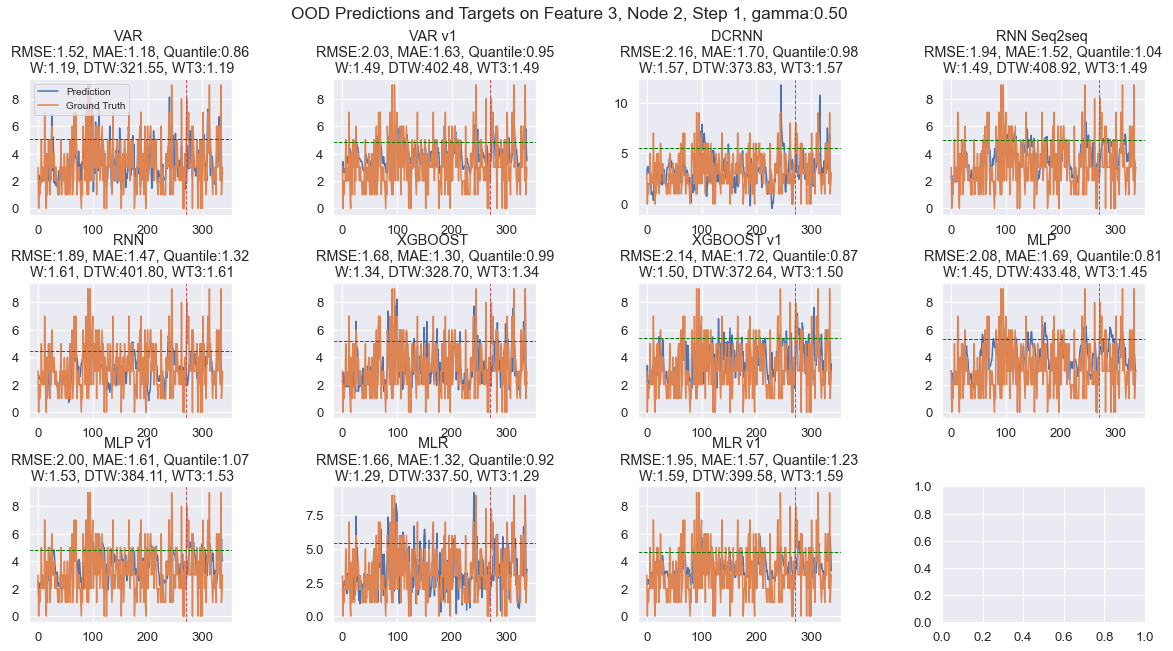

In [655]:
node = 2 - 1
feature = 2
step = 0
end = target.shape[0]
#l1:mae l2:rmse l3:quantile l4:weighted l5:weighted3 l6:dtw
l1, l2, l3, l4, l5, l6 = plot_node_specific(vis_list, target, model_names,
                                   step=step, node=node, feature=feature, rho=0.9, timespan=3, r=[0,end],
                                   path="./fig", gamma=0.5, acd=270, mode=mode, avg=False, save=False)

In [645]:
def plot_pred_ground_truth(vis_list, target, step, node, feature, mdl,
                           model_names, rho=0.9, timespan=2, save=False):
    fig, ax = plt.subplots(figsize=(18, 5))  # Create a new Figure object and set its size
    sns.lineplot(x=np.arange(start=0, stop=target.shape[0]), y=vis_list[mdl][:, step, node, feature], label=f'{model_names[mdl]}', ax=ax)
    sns.lineplot(x=np.arange(start=0, stop=target.shape[0]), y=target[:, step, node, feature], label='Ground Truth', ax=ax)
    ax.axhline(y=np.quantile(vis_list[mdl][:, step, node, feature], q=rho), color='red', linestyle='--', linewidth=1, label="Quantile of prediction")
    ax.axhline(y=np.quantile(target[:, step, :, feature], q=rho), color='black', linestyle='--', linewidth=1, label="Quantile of ground truth overall")
    ax.axhline(y=np.quantile(target[:, step, node, feature], q=rho), color='green', linestyle='--',
               linewidth=1, label=f"Quantile of ground truth at node {node+1}")
    ax.axvline(x=270, color='b', linestyle='--', linewidth=1, label="Accident") #draw the accident verticalline

    plt.xlabel('Time: 10s', fontsize=15)
    plt.ylabel('Count of Pedestrian', fontsize=15)
    plt.legend(loc='upper right')
    if save:
        plt.savefig(f'./fig/{model_names[mdl]}_Node{node}_'+str(step)+'.pdf')
    plt.show()

    end = target.shape[0]
    mae1 = masked_mae_np(vis_list[mdl][:end, :, node, feature], target[:end, :, node, feature])
    print(f'MAE: {mae1:.2f}')
    mae = masked_mae_np(vis_list[mdl][:end, step, node, feature], target[:end, step, node, feature])
    print(f'MAE Step{step}: {mae:.2f}')
    rmse1 = masked_rmse_np(vis_list[mdl][:end, :, node, feature], target[:end, :, node, feature])
    print(f'RMSE: {rmse1:.2f}')
    rmse = masked_rmse_np(vis_list[mdl][:end, step, node, feature], target[:end, step, node, feature])
    print(f'RMSE Step{step}: {rmse:.2f}')
    qt1 = np.mean(rho_risk(vis_list[mdl][:end, :, node, feature], target[:end, :, node, feature], timespan=timespan, rho=rho))
    print(f'Quantile Loss: {qt1:.2f}')
    qt = np.mean(rho_risk(vis_list[mdl][:end, step, node, feature], target[:end, step, node, feature], timespan=timespan, rho=rho))
    print(f'Quantile Loss Step{step}: '
          f'{qt:.2f}')
    print(f'Weighted Loss: {weighted_loss(rmse1, qt1, gamma=0.5):.2f}')
    print(f'Weighted Loss Step{step}: {weighted_loss(rmse, qt, gamma=0.5):.2f}')
    ldtw = calculate_dtw_distance(vis_list[mdl][:end, step, node, feature], target[:end, step, node, feature])
    _, wt3, g = weighted_average_loss(vis_list[mdl][:end, ...],
                                      target[:end,...], rho=rho, timespan=timespan)
    print(f'DTW Step{step}: {ldtw:.2f}')
    print(f'Weighted Average Loss Step{step}: {wt3[step, node, feature]:.2f}, gamma:{g[step, node, feature]:.2f}')


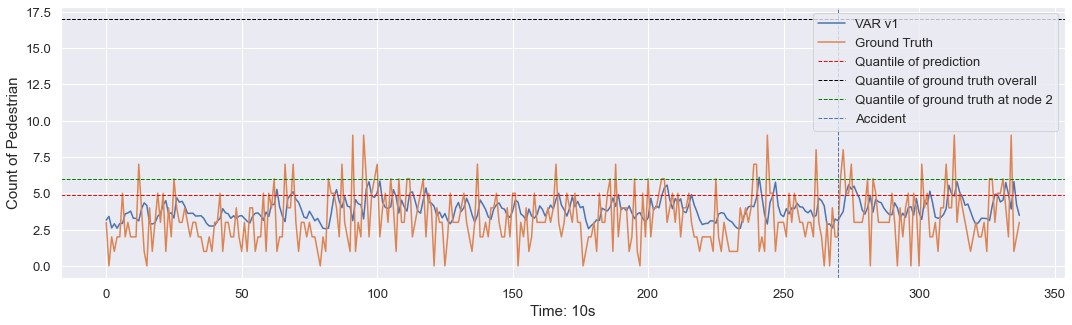

MAE: 1.86
MAE Step0: 1.63
RMSE: 2.20
RMSE Step0: 2.03
Quantile Loss: 1.11
Quantile Loss Step0: 1.07
Weighted Loss: 1.66
Weighted Loss Step0: 1.55
DTW Step0: 402.48
Weighted Average Loss Step0: 1.55, gamma:0.50


In [649]:
plot_pred_ground_truth(vis_list, target, step=step, node=node, feature=2, mdl=1, model_names=model_names, timespan=3)

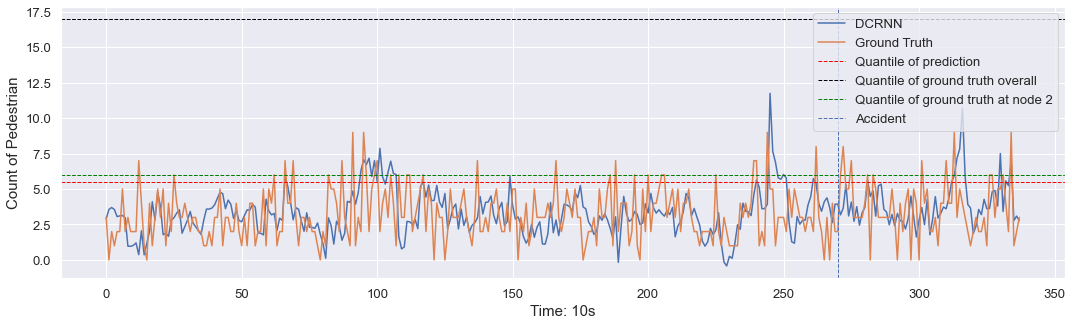

MAE: 1.57
MAE Step0: 1.70
RMSE: 2.01
RMSE Step0: 2.16
Quantile Loss: 1.36
Quantile Loss Step0: 0.98
Weighted Loss: 1.68
Weighted Loss Step0: 1.57
DTW Step0: 373.83
Weighted Average Loss Step0: 1.57, gamma:0.50


In [653]:
plot_pred_ground_truth(vis_list, target, step=step, node=node, feature=2, mdl=2, model_names=model_names, timespan=3)

In [656]:
def rank_loss_list(loss_list, reverse=False):
    sorted_id = sorted(range(len(loss_list)), key=lambda k: loss_list[k], reverse=reverse)
    return np.sort(loss_list), [model_names[id] for id in sorted_id]

rank_loss_list(l5)

(array([1.18911806, 1.29001239, 1.3366555 , 1.44798689, 1.48868005,
        1.48884192, 1.50326995, 1.53240067, 1.56895129, 1.58878041,
        1.60855744]),
 ['VAR',
  'MLR',
  'XGBOOST',
  'MLP',
  'RNN Seq2seq',
  'VAR v1',
  'XGBOOST v1',
  'MLP v1',
  'DCRNN',
  'MLR v1',
  'RNN'])

In [614]:
rank_loss_list(l5)

(array([10.24536338, 11.41486657, 12.22425669, 12.89010741, 15.56926998,
        17.29067634, 17.32688118, 21.05719889, 22.5095186 , 23.06089838,
        34.53867738]),
 ['XGBOOST',
  'RNN',
  'MLR',
  'RNN Seq2seq',
  'XGBOOST v1',
  'VAR',
  'MLP v1',
  'DCRNN',
  'VAR v1',
  'MLR v1',
  'MLP'])

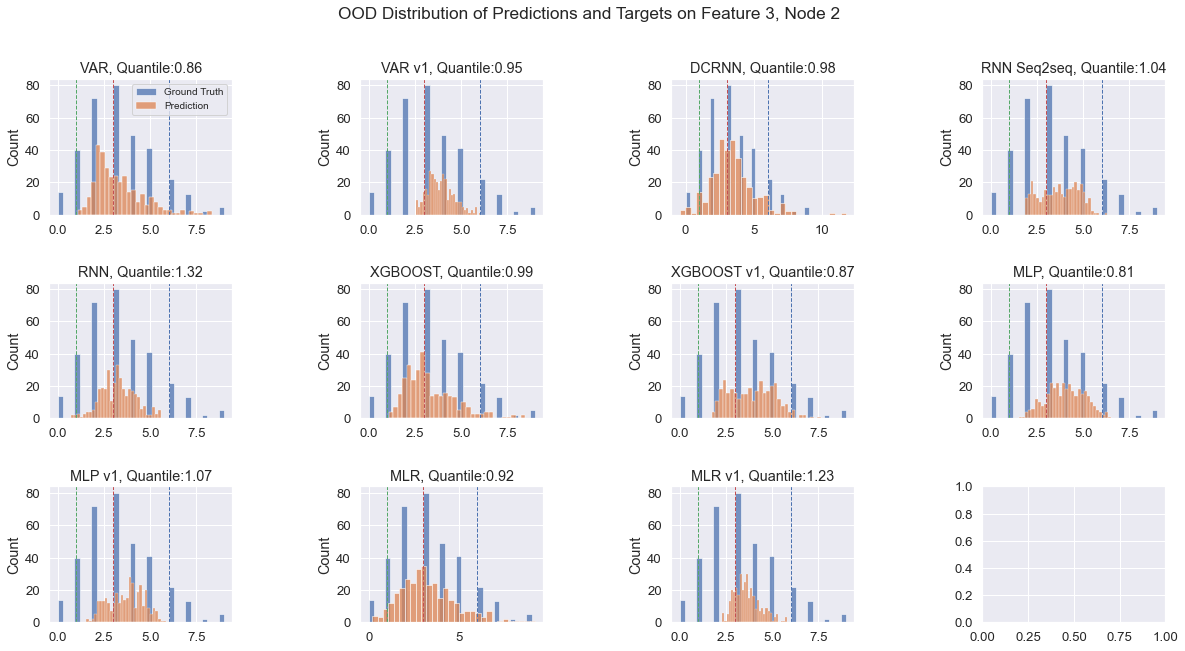

In [657]:
def plot_time_series_distribution(pred, target, step, node, feature, rho, timespan, models=None):
    """
    Plot the time series distribution of the target and prediction
    """
    sns.set(style='darkgrid', font_scale=1.2)
    fig, axes = plt.subplots(3, 4, figsize=(20, 10))
    fig.subplots_adjust(hspace=0.5)
    fig.subplots_adjust(wspace=0.7)
    q = np.quantile(target[:, step, node, feature], q=[0.1, 0.5, 0.9])
    n = 0

    for i in range(3): # row
        for j in range(4): # column
            if n < len(vis_list):
                sns.histplot(data = target[:, step, node, feature], ax=axes[i, j], label=f'Ground Truth', bins=30)
                sns.histplot(data = pred[n][:, step, node, feature], ax=axes[i, j], label=f'Prediction', bins=30)
                qt_loss = np.mean(rho_risk(pred[n][:, step, node, feature],
                                       target[:, step, node, feature], timespan=timespan, rho=rho))
                qt = np.quantile(pred[n][:, step, node, feature], q=[0.1, 0.5, 0.9])
                if n == 0:
                    axes[i, j].legend(fontsize=10)
                else:
                    axes[i, j].legend().set_visible(False)
                axes[i, j].axvline(x=q[0], color='g', linestyle='--', linewidth=1) #draw quantile line 0.1
                axes[i, j].axvline(x=q[1], color='r', linestyle='--', linewidth=1) #draw quantile line 0.9
                axes[i, j].axvline(x=q[2], color='b', linestyle='--', linewidth=1) #draw quantile line 0.5
                axes[i, j].set_title(f'{models[n]}, Quantile:{qt_loss:.2f}')
                n += 1
            else:
                pass

    fig.suptitle(f'{mode} Distribution of Predictions and Targets on Feature {feature+1}, Node {node+1}')
    plt.show()

plot_time_series_distribution(vis_list, target, step=step, node=node, feature=feature, timespan=3, rho=0.9, models=model_names)

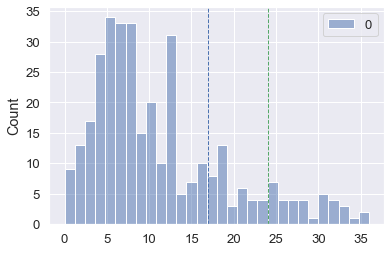

In [665]:
# ax = sns.histplot(data = target[:, 0, :, 2].reshape(-1, 1), label=f'Ground Truth', bins=30)
ax = sns.histplot(data = target[:, 0, 18, 2].reshape(-1, 1), label=f'Ground Truth', bins=30)
ax.axvline(x=np.quantile(target[:, 0, :, 2].reshape(-1, 1), q=0.9), color='b', linestyle='--', linewidth=1)
ax.axvline(x=np.quantile(target[:, 0, 18, 2].reshape(-1, 1), q=0.9), color='g', linestyle='--', linewidth=1)

In [617]:
def plot_weighted_loss_line(L1, L2, models):
    """
    For experiment of distinctiveness, actually is not weighted loss, is a comparison between the
    normalized metric
    Plot gamma: Analyse different gamma, different models perfomance
    """
    gamma = np.arange(0, 1.1, 0.1)
    # normalized loss comparison, L shape [gamma, models]
    L = ((1-gamma).reshape([-1, 1]) @ (np.array(L1)/np.sum(np.array(L1))).reshape([1, -1])
          + gamma.reshape([-1, 1]) @ (np.array(L2)/np.sum(np.array(L2))).reshape([1, -1]))
    # L = ((1-gamma).reshape([-1, 1]) @ np.array(L1).reshape([1, -1])
    #      + gamma.reshape([-1, 1]) @ np.array(L2).reshape([1, -1]))

    fig, ax = plt.subplots(figsize=(7, 9))
    for i in range(len(L1)):
        sns.lineplot(x=gamma, y=L[:, i], label=model_names[i], ax=ax)
        plt.text(gamma[-1], L[:, i][-1], f'{models[i]}', ha='right', va='bottom', fontsize=10)
    # Show y-ticks on both sides
    plt.tick_params(axis='y', which='both', left=True, right=True)
    # Add y-title to the left side
    plt.ylabel("Normalized RMSE", fontsize=12)
    plt.xlabel("γ", fontsize=15)
    # Create a second y-axis on the right side
    ax2 = plt.gca().twinx()
    ax2.set_ylim(ax.get_ylim())
    # Add y-title to the right side
    ax2.set_ylabel("Normalized Quantile Loss", fontsize=12)
    # Remove the legend inside the figure
    ax.legend().set_visible(False)
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Models")
    # plt.show()
    # plt.savefig(f'./fig/weighted_loss_line_{mode}.pdf', bbox_inches='tight')
    # return L
def plot_weighted_loss_box(L1, L2, models):
   gamma = np.arange(0, 1.1, 0.1)
   L = ((1-gamma).reshape([-1, 1]) @ np.array(L1).reshape([1, -1])
        + gamma.reshape([-1, 1]) @ np.array(L2).reshape([1, -1]))

   # L = ((1-gamma).reshape([-1, 1]) @ (np.array(L1)/np.sum(np.array(L1))).reshape([1, -1])
   #        + gamma.reshape([-1, 1]) @ (np.array(L2)/np.sum(np.array(L2))).reshape([1, -1]))
   fig, ax = plt.subplots(figsize=(8, 5))
   sns.boxplot(L, ax=ax)
   plt.ylabel("Model Performance of Two Metrics", fontsize=15)
   plt.xlabel("Models", fontsize=15)
   plt.xticks(np.arange(len(models)), models, rotation=45, fontsize=10)
   plt.savefig(f'./fig/weighted_loss_box_{mode}.pdf', bbox_inches='tight')

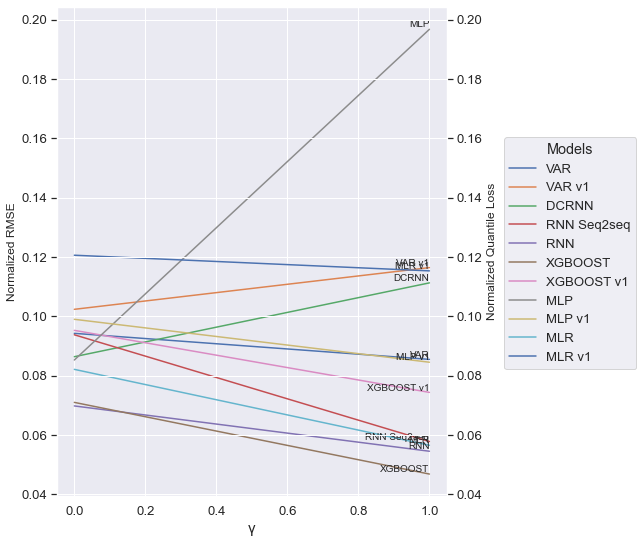

In [618]:
plot_weighted_loss_line(l2, l3, model_names)

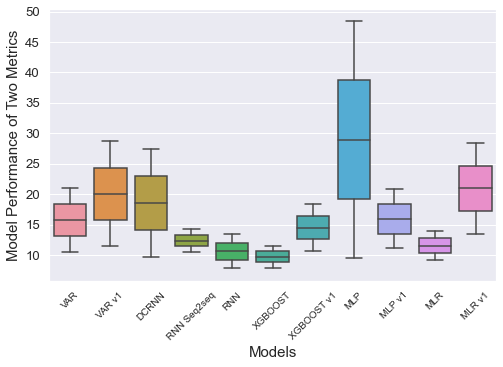

In [619]:
# the value of middle line of each box is actually the weighted loss
plot_weighted_loss_box(l2, l3, model_names)

In [620]:
#visualize quantile loss, per node per feature
mdl = 3
rho = 0.9

def visualize_timespan(target, predictions, mdl, rho, step, node,
                       feature, models, timespan):

    Z = np.sum(target.reshape([-1, timespan, target.shape[2], target.shape[3]]), axis=1)[:, node, feature] # the node and feat is not summed, Z: [N, nodes, features]; preds: [N, nodes, features]
    Z_hat = np.sum(predictions[mdl].reshape([-1, timespan, target.shape[2], target.shape[3]]), axis=1)[:, node, feature]
    # qt_loss, _ = quantile_loss_np(predictions[mdl][..., node, feature], target[..., node, feature], timespan=timespan, rho=0.9)
    qt_loss = np.mean(rho_risk(predictions[mdl][..., node, feature], target[..., node, feature], timespan=timespan, rho=0.9))
    print(qt_loss)
    fig, axes = plt.subplots(1, 2, figsize=(16,8))
    ax = np.arange(Z.shape[0])
    sns.lineplot(x=ax, y=Z, ax=axes[0], label = "gt") # sum of gt
    sns.lineplot(x=ax, y=Z_hat, ax=axes[0], label = f"{models[mdl]}") # sum of prediction
    # sns.lineplot(x=ax, y=np.quantile(Z_hat[mdl], rho) * np.ones(ax.shape), ax=axes[0], label = "quantile") # quantile number
    sns.lineplot(x=ax, y=np.quantile(Z_hat, rho) * np.ones(ax.shape), ax=axes[0], label = "quantile") # quantile number
    # L = quantile_loss(Z, Z_hat[mdl], rho)
    ax2 = np.arange(predictions[mdl].shape[0])
    sns.lineplot(x=ax2, y=target[:, step, node, feature], ax=axes[1], label = "gt") # target after inverse transform
    sns.lineplot(x=ax2, y=predictions[mdl][:, step, node, feature], ax=axes[1], label = "pred") # prediction after inverse transform
    # plt.plot(ax, Z_hat[0] - Z, label = "diff")
    plt.legend()

# visualize_timespan(target, vis_list, mdl=mdl, rho=rho, step=step, node=node, feature=feature, models=model_names, timespan=2)

In [621]:
# visualize_timespan(target, vis_list, mdl=4, rho=rho, step=step, node=node, feature=feature, models=model_names, timespan=2)

### Density Map

In [668]:
# Error map, Density Map
# The node and feat is not summed, z: [N, nodes, features]; preds: [N, nodes, features]
def show_density_map(values, feature, save=False):
    """
    values: 3 dimension [N, node, features]
    """
    # pos: node position
    pos = np.array([2, 20, 22, 21, 19, 8, 18, 23, 13, 17, 15, 16, 14,
                    27, 25, 30, 24, 12, 10, 11, 9, 26, 28, 34, 31,
                    7 ,5, 6, 4, 29, 33, 35, 32, 3, 1]) - 1
    # L = ae_loss(Z[:,:,:,2], Z_hat[mdl][:,:,:,2])
    # Create a color map
    cmap = plt.cm.get_cmap('hot')
    fig, ax = plt.subplots(figsize=(10, 8))
    # Plot the heat map
    im = ax.imshow(values[..., pos, feature].T, cmap=cmap, aspect='auto') # two dimension, [N, pos]

    ax.grid(False)
    ax.set_yticks(np.arange(len(pos)))
    ax.set_yticklabels(pos+1)
    # Add a color bar
    ax.figure.colorbar(im, ax=ax)
    ax.set_xlabel("Time: 10s", fontsize=15)
    ax.set_ylabel("Sensor ID", fontsize=15)
    ax.set_title("Error Density Map", fontsize=16)
    if save:
        plt.savefig(f"./fig/error_density_map_{feature}.pdf")

def nodes_correlations(data, adjacency, step=11, feature=2):
    """
    data: [N, steps, node, features]
    """
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    ax[0].set_title("Correlation Matrix", fontsize=16)  # Set title for the first subfigure
    ax[1].set_title("Adjacency Matrix", fontsize=16)  # Set title for the second subfigure

    # Extract the data for the given step and feature
    data_subset = data[:, step, :, feature]
    # Calculate the Pearson correlation matrix
    correlations = np.corrcoef(data_subset.T)
    # Plot the correlation matrix as a heatmap
    sns.heatmap(correlations, cmap="coolwarm", annot=False, ax=ax[0])
    sns.heatmap(adjacency, cmap="coolwarm", annot=False, ax=ax[1])
    # Add x and y axis labels for both subfigures
    ax[0].set_xlabel("Sensor ID", fontsize=15)
    ax[0].set_ylabel("Sensor ID", fontsize=15)
    ax[1].set_xlabel("Sensor ID", fontsize=15)
    ax[1].set_ylabel("Sensor ID", fontsize=15)
    # plt.savefig(f'./fig/node_correlation.pdf')

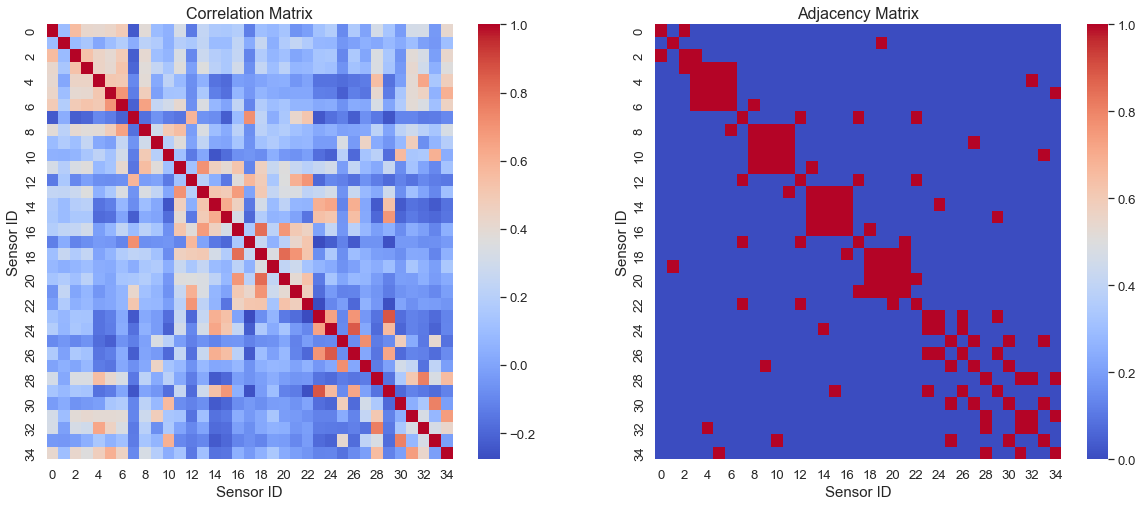

In [623]:
nodes_correlations(target, adj_mat.toarray(), step=0, feature=2)

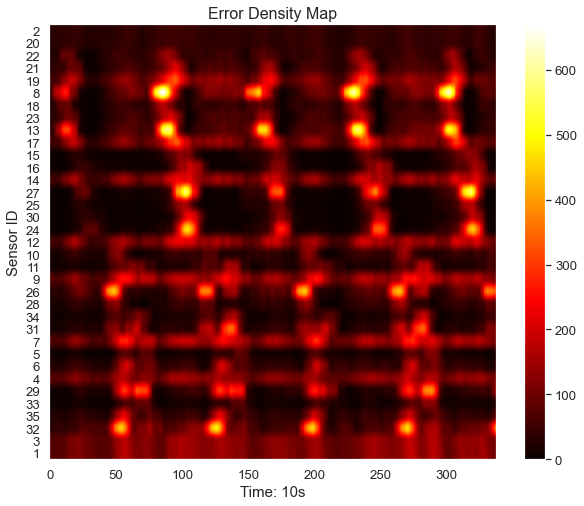

In [669]:
show_density_map(np.sum(target, axis=1), feature=2) # average over 12 steps (2 mins), so the shape is [N, Node, Features]
# show_density_map(target[:, 11, ...], feature=2) # average over 12 steps (2 mins), so the shape is [N, Node, Features]

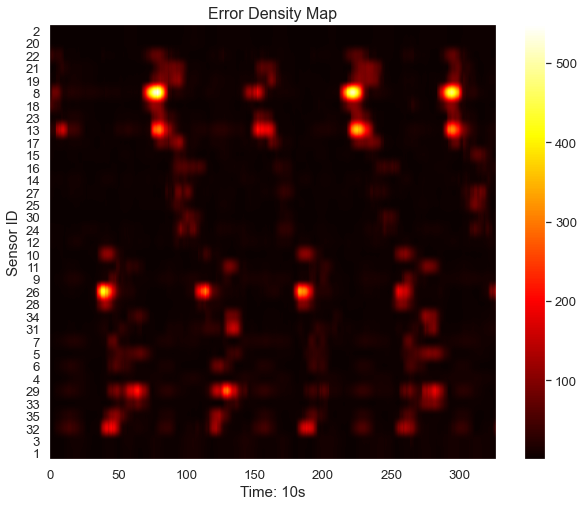

In [670]:
# L = quantile_loss(target, vis_list[5], timesteps=12, rho=0.9) # sum over steps, L: [N, node, feature]
L = rho_risk(vis_list[3], target, timespan=12, rho=0.9) # sum over steps, L: [N, node, feature]
show_density_map(np.mean(L, axis=1), feature=2, save=True)

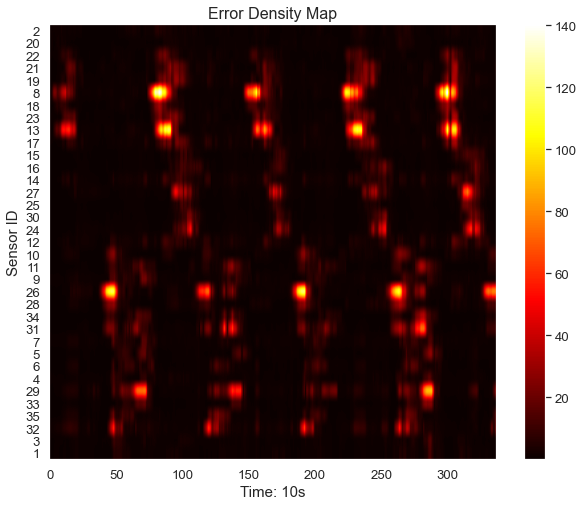

In [671]:
L = rho_risk(vis_list[2], target, timespan=2, rho=0.9) # sum over steps, L: [N, node, feature]
show_density_map(np.mean(L, axis=1), feature=2)

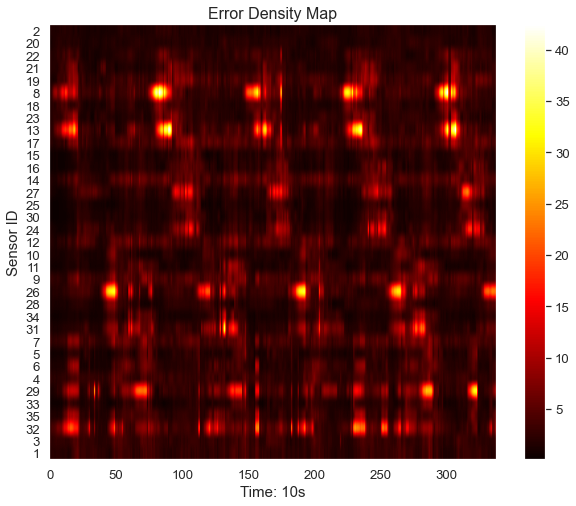

In [672]:
# L = np.mean(ae_loss(target, vis_list[3]), axis=1) # sum over steps, L: []
L = ae_loss(target, vis_list[2])
show_density_map(np.mean(L, axis=1), feature=2)

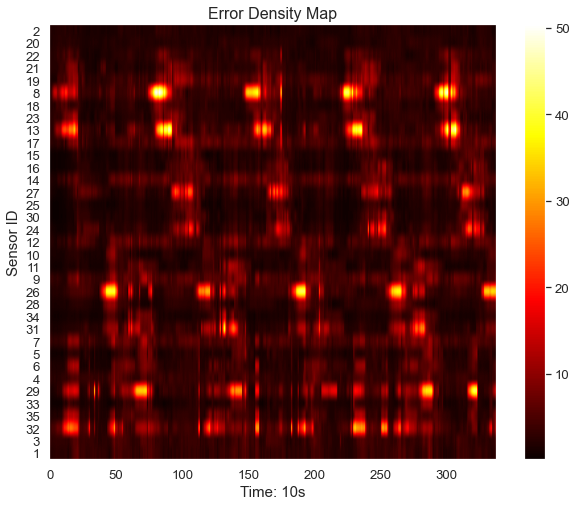

In [673]:
L = se_loss(target, vis_list[2])
show_density_map(np.sqrt(np.mean(L, axis=1)), feature=2)

### Overall Evaluation

In [629]:
"""
Average over all the node in one scenario,
if the feature is indicated, the error is calculated for that feature
"""

gamma = 0.5
qt_list = []
mae_list =[]
rmse_list = []
wt_list = []
wt2_list = []
dtw_list = []
wt3_list = []
# r2_list = []
# subset = np.array([2, 4, 8, 13, 9, 26, 31, 29, 3, 32]) - 1
# subset = np.arange(35)
subset = np.array([31]) - 1
feature = 2
step = 12
timespan = 2
rho = 0.9
for pred in vis_list:
    # L = quantile_loss(target, pred, timesteps=2, rho=0.9)
    L = rho_risk(pred, target, timespan=timespan, rho=rho)
    # qt_list.append(np.mean(L, axis=(0,1))[feature])
    qt_list.append(np.mean(L[..., :step, subset, feature]))
    mae = masked_mae_np(pred[..., :step, subset, feature], target[..., :step, subset, feature])
    rmse = masked_rmse_np(pred[..., :step, subset, feature], target[..., :step, subset, feature])
    # wt = gamma * np.mean(L, axis=(0,1))[feature] + (1-gamma) * mae
    ldtw = calculate_dtw_distance(pred[..., :step, subset, feature], target[..., :step, subset, feature])
    r2 = r2_score(target[..., :step, subset, feature].reshape([-1, 1]), pred[..., :step, subset, feature].reshape([-1, 1]))
    wt = weighted_loss(rmse, np.mean(L[..., :step, subset, feature]), gamma=gamma)
    wt_list.append(wt)
    # wt2_list.append(wt + np.abs(wt - mae))
    wt2_list.append(sum_weighted_loss(rmse, np.mean(L[..., :step, subset, feature])))
    _, wt3, _ = weighted_average_loss(pred, target, rho=rho, timespan=timespan)
    # print(wt3.shape)
    wt3_list.append(np.mean(wt3[..., :step, subset, feature]))
    mae_list.append(mae)
    rmse_list.append(rmse)
    dtw_list.append(ldtw)

    # r2_list.append(-r2)

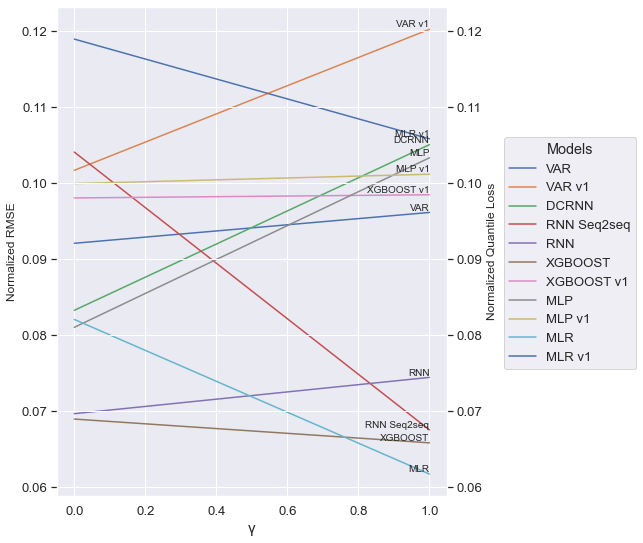

In [630]:
plot_weighted_loss_line(rmse_list, qt_list, model_names)

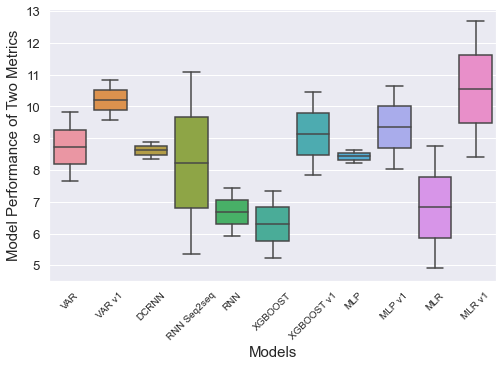

In [631]:
plot_weighted_loss_box(rmse_list, qt_list, model_names)

In [632]:
rank_loss_list(wt3_list)

(array([5.96136268, 6.24965931, 6.44279949, 7.37989323, 8.35693896,
        8.37210545, 8.50312569, 8.70328344, 8.92013489, 9.85466416,
        9.95720125]),
 ['XGBOOST',
  'MLR',
  'RNN',
  'RNN Seq2seq',
  'MLP',
  'VAR',
  'DCRNN',
  'XGBOOST v1',
  'MLP v1',
  'MLR v1',
  'VAR v1'])

In [633]:
rank_loss_list(wt_list)

(array([ 6.29154012,  6.67175917,  6.82701745,  8.23272743,  8.42702361,
         8.61537298,  8.73073802,  9.14139295,  9.34973024, 10.2014283 ,
        10.54889178]),
 ['XGBOOST',
  'RNN',
  'MLR',
  'RNN Seq2seq',
  'MLP',
  'DCRNN',
  'VAR',
  'XGBOOST v1',
  'MLP v1',
  'VAR v1',
  'MLR v1'])

In [634]:
rank_loss_list(mae_list)

(array([4.532189 , 5.0786953, 5.099443 , 5.809321 , 6.434605 , 6.59285  ,
        6.79304  , 6.8420897, 6.92009  , 8.114653 , 8.937076 ],
       dtype=float32),
 ['XGBOOST',
  'RNN',
  'DCRNN',
  'MLP',
  'MLR',
  'VAR',
  'RNN Seq2seq',
  'XGBOOST v1',
  'MLP v1',
  'VAR v1',
  'MLR v1'])

In [635]:
rank_loss_list(rmse_list)

(array([ 7.349906 ,  7.4254026,  8.637272 ,  8.747631 ,  8.87637  ,
         9.816726 , 10.452939 , 10.654564 , 10.8410425, 11.096448 ,
        12.682081 ], dtype=float32),
 ['XGBOOST',
  'RNN',
  'MLP',
  'MLR',
  'DCRNN',
  'VAR',
  'XGBOOST v1',
  'MLP v1',
  'VAR v1',
  'RNN Seq2seq',
  'MLR v1'])

In [636]:
rank_loss_list(qt_list)

(array([4.90640382, 5.23317428, 5.36900692, 5.9181157 , 7.64475031,
        7.82984687, 8.04489657, 8.21677534, 8.35437553, 8.41570234,
        9.56181407]),
 ['MLR',
  'XGBOOST',
  'RNN Seq2seq',
  'RNN',
  'VAR',
  'XGBOOST v1',
  'MLP v1',
  'MLP',
  'DCRNN',
  'MLR v1',
  'VAR v1'])

In [637]:
rank_loss_list(dtw_list)

(array([ 6629.53139959,  7154.47158056,  7429.04620209,  8198.80439732,
         8854.40136539,  9051.32502094,  9219.68886709,  9333.5525816 ,
         9506.34358296, 10002.92707903, 10365.95618184]),
 ['XGBOOST',
  'RNN',
  'DCRNN',
  'MLP',
  'VAR',
  'MLR',
  'RNN Seq2seq',
  'MLP v1',
  'XGBOOST v1',
  'MLR v1',
  'VAR v1'])